# DC Simulation
This notebook aims at simulating the DC case, with the following assumptions:
- 10-node network
- full observability: the current and the voltage at each node is measured
- Gaussian noise: the measurement noise on current and voltage is Gaussian
- independent noise: the noise on each node is independent and the noise on current and voltage on the same node is independent
- the noise has zero mean and standard deviation `noise_sigma` on each node and variable
- a number `n_samples` of samples is collected
- the voltage on each node is independent, has a Gaussian distribution with mean 1 and standard deviation `v_sigma`

We are not going to use here the solver from the main codebase to keep the experimentation harmless.

## Case study: initialization from actual admittance matrix
In this report, we want to check what happens if we start the block coordinate descent of s-tls from the optimal point (e.g. actual admittance matrix and actual noise on voltages). Strangely - and quite annoyingly - the algorithm converges to a different optimum and the estimation of the admittance matrix deteriorates.

## Setup

We create the admittance matrix and we simulate the voltage and current

In [1]:
import numpy as np
import cvxpy as cp
import seaborn as sns
from numpy.random import default_rng
from matplotlib import pyplot as plt

import sys
from tqdm.notebook import tqdm
sys.path.append('..')
from src.identification.error_metrics import error_metrics, fro_error

In [2]:
v_sigma = 0.1
noise_sigma = 0.001
n_samples = 300

actual_admittance = np.array([
    [2, -1, -1, 0, 0, 0, 0, 0, 0, 0],
    [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, -2, 0, 0, 0, 0, 0],
    [0, 0, 0, -2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, -1],
    [0, 0, 0, 0, 0, 0, 2, -1, 0, -1],
    [0, 0, 0, 0, 0, 0, -1, 2, -1, 0],
    [0, 0, 0, 0, 0, 0, 0, -1, 1, 0],
    [0, 0, 0, 0, 0, -1, -1, 0, 0, 2],
])

n_nodes = actual_admittance.shape[0]

Let's not be stupid again and let us check that the admittance matrix is Laplacian and symmetric.

In [3]:
np.testing.assert_array_equal(actual_admittance, actual_admittance.T)
np.testing.assert_array_equal(np.sum(actual_admittance, axis=1), np.zeros(n_nodes))

In [4]:
rng = default_rng(11)
actual_voltages = rng.normal(1, v_sigma, (n_samples, n_nodes))
actual_currents = actual_voltages @ actual_admittance
noise_voltages = rng.normal(0, noise_sigma, (n_samples, n_nodes))
noise_currents = rng.normal(0, noise_sigma, (n_samples, n_nodes))
measured_voltages = actual_voltages + noise_voltages
measured_currents = actual_currents + noise_currents

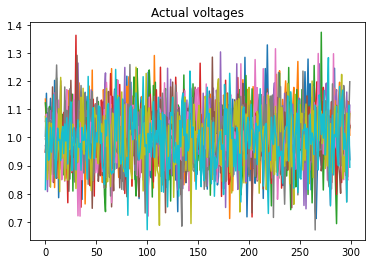

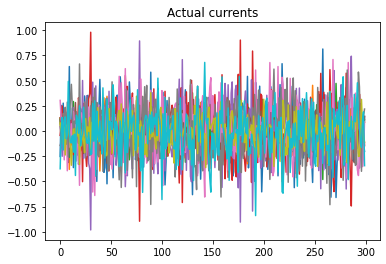

In [5]:
plt.plot(actual_voltages)
plt.title('Actual voltages')
plt.show()

plt.plot(actual_currents)
plt.title('Actual currents')
plt.show()

Of course, actual currents and voltages are not realistic and real networks would result in much more correlated voltages and smaller currents.
Still, we'll start from the simplest condition.

## Lasso estimation
We try first with a standard LASSO algorithm.
The optimization problem is solved with `cvxopt` and `gurobi`.
The hypterparameter $\lambda$ is chosen against the real admittance matrix.
Again, this is not realistic, but it is the simplest way.

In [6]:
def lasso(x: np.array, y: np.array, actual_beta: np.array):
    n = x.shape[1]
    l = cp.Parameter(nonneg=True)
    beta = cp.Variable((n, n))

    def lasso_loss(x, y, beta, l):
        return cp.norm2(cp.vec(y - x @ beta)) ** 2 + l * cp.norm1(cp.vec(beta))

    problem = cp.Problem(cp.Minimize(lasso_loss(x, y, beta, l)))

    l_values = np.logspace(-6, -1, 50)
    cv_trials = []

    for l_value in l_values:
        l.value = l_value
        problem.solve()
        cv_trials.append((l.value, beta.value, fro_error(beta.value, actual_beta)))

    return cv_trials

lasso_trials = lasso(measured_voltages, measured_currents, actual_admittance)
lasso_best_trial = min(lasso_trials, key=lambda t: t[2])
lasso_lambda, lasso_admittance = lasso_best_trial[0], lasso_best_trial[1]
lasso_error = error_metrics(actual_admittance, lasso_admittance)
print(f'Best lambda: {lasso_lambda}')
lasso_error

Best lambda: 0.004714866363457394


ErrorMetrics(fro_error=0.010811299340321646, max_error=0.0035050484686944827, rrms_error=0.0015604766461060815, map_error=0.0011111371696573696)

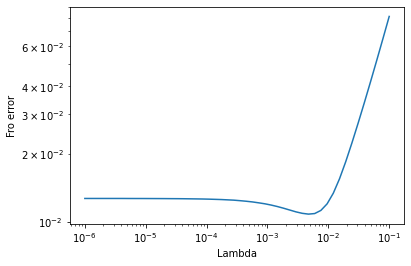

In [7]:
lasso_lambdas, _, lasso_fro_err = zip(*lasso_trials)
plt.loglog(lasso_lambdas, lasso_fro_err)
plt.xlabel('Lambda')
plt.ylabel('Fro error');

## TLS estimation
As all the matrices are real-valued, we do not need any transformation to apply TLS

In [8]:
def tls(x: np.array, y:np.array) -> np.array:
    n = x.shape[1]
    u, s, vh = np.linalg.svd(np.block([x, y]))
    v = vh.conj().T
    v_xy = v[:n, n:]
    v_yy = v[n:, n:]
    beta = - v_xy @ np.linalg.inv(v_yy)
    return beta

tls_admittance = tls(measured_voltages, measured_currents)
tls_error = error_metrics(actual_admittance, tls_admittance)
tls_error

ErrorMetrics(fro_error=0.012567866041093185, max_error=0.004203170630493845, rrms_error=0.0018140152104910768, map_error=0.0007713225550368824)

## S-TLS estimation
Finally, we use our Sparse-TLS estimation, initially in its plain form - no priors, no optimization tuning.

In [9]:
MAX_ITERATIONS = 100
ABS_TOL = 1e-8
REL_TOL = 1e-8
l = 4e-4 # lasso_lambda

def is_stationary_point(f_cur, f_prev, abs_tol, rel_tol):
    return np.abs(f_cur - f_prev) < abs_tol or np.abs(f_cur - f_prev) / np.abs(f_prev) < rel_tol

def target_loss(x, dx_value, y, beta_value, l):
    return cp.norm2(cp.vec(y - (x - dx_value) @ beta_value)) ** 2 + cp.norm2(cp.vec(dx_value)) ** 2 + l * cp.norm1(cp.vec(beta_value))

def lasso_loss(x, dx_value, y, beta, l):
    return cp.norm2(cp.vec(y - (x - dx_value) @ beta)) ** 2 + l * cp.norm1(cp.vec(beta))

def ls_loss(x, dx, y, beta_value):
    return cp.norm2(cp.vec(y - (x - dx) @ beta_value)) ** 2 + cp.norm2(cp.vec(dx)) ** 2

In [10]:
x = measured_voltages.copy()
dx = cp.Variable(x.shape)
# dx_value = np.zeros_like(x)
dx_value = noise_voltages
y = measured_currents.copy()
beta = cp.Variable(actual_admittance.shape)
# beta_value = np.zeros_like(actual_admittance)
beta_value = actual_admittance

stls_iterations = []
for i in tqdm(range(MAX_ITERATIONS)):
    # solve lasso problem
    lasso_prob = cp.Problem(cp.Minimize(lasso_loss(x, dx_value, y, beta, l)))
    lasso_prob.solve()
    beta_value = beta.value

    # solve ols problem
    ls_prob = cp.Problem(cp.Minimize(ls_loss(x, dx, y, beta_value)))
    ls_prob.solve()
    dx_value = dx.value

    # update cost function
    target = target_loss(x, dx_value, y, beta_value, l).value
    stls_iterations.append((i, target, fro_error(actual_admittance, beta_value)))

    # check terminal condition
    if i > 0 and is_stationary_point(target, stls_iterations[i - 1][1], ABS_TOL, REL_TOL):
        break

stls_admittance = beta_value
stls_error = error_metrics(actual_admittance, stls_admittance)
stls_error

C:\Users\donle\anaconda3\envs\eiv-grid-id\lib\site-packages\cvxpy\problems\problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


ErrorMetrics(fro_error=0.010544364491352641, max_error=0.003357876592955833, rrms_error=0.0015219479193789949, map_error=0.000987124273584536)

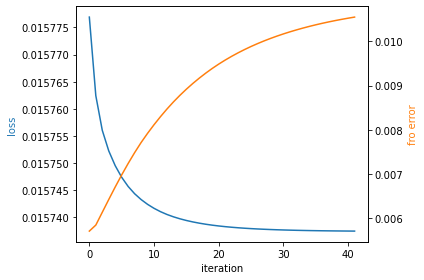

In [11]:
it_series, target_series, error_series = zip(*stls_iterations)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss', color='#1f77b4' )
plt.plot(it_series, target_series, label='loss', color='#1f77b4')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('fro error', color='#ff7f0e')
ax2.plot(it_series, error_series, label='fro error', color='#ff7f0e')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Evaluation

In [12]:
lasso_abs_err = np.abs(lasso_admittance - actual_admittance)
tls_abs_err = np.abs(tls_admittance - actual_admittance)
stls_abs_err = np.abs(stls_admittance - actual_admittance)

max_err = max(np.max(lasso_abs_err), np.max(tls_abs_err), np.max(stls_abs_err))

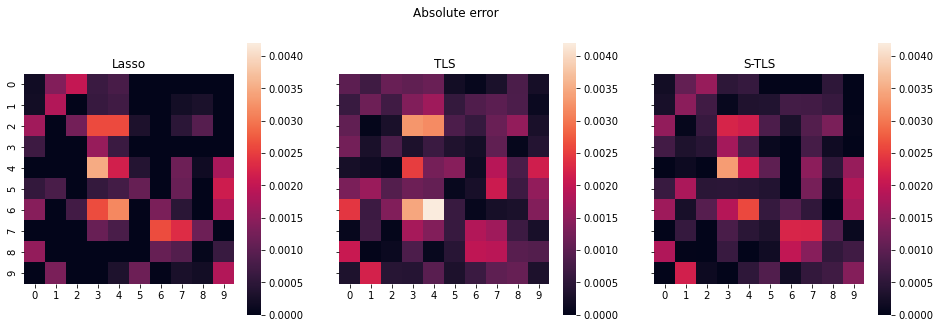

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
fig.suptitle('Absolute error')

sns.heatmap(lasso_abs_err, ax=axes[0], vmin=0, vmax=max_err, square=True)
axes[0].set_title('Lasso')

sns.heatmap(tls_abs_err, ax=axes[1], vmin=0, vmax=max_err, square=True)
axes[1].set_title('TLS')

sns.heatmap(stls_abs_err, ax=axes[2], vmin=0, vmax=max_err, square=True)
axes[2].set_title('S-TLS');

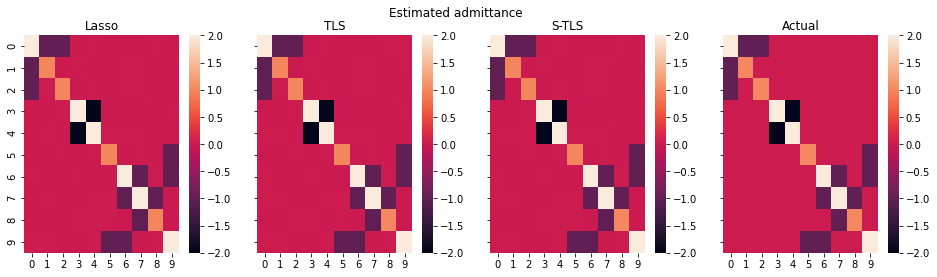

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
fig.suptitle('Estimated admittance')

sns.heatmap(lasso_admittance, ax=axes[0], vmin=np.min(actual_admittance), vmax=np.max(actual_admittance))
axes[0].set_title('Lasso')

sns.heatmap(tls_admittance, ax=axes[1], vmin=np.min(actual_admittance), vmax=np.max(actual_admittance))
axes[1].set_title('TLS')

sns.heatmap(stls_admittance, ax=axes[2], vmin=np.min(actual_admittance), vmax=np.max(actual_admittance))
axes[2].set_title('S-TLS');

sns.heatmap(actual_admittance, ax=axes[3], vmin=np.min(actual_admittance), vmax=np.max(actual_admittance))
axes[3].set_title('Actual');